В данном семинаре мы рассмотрим простой пример применения генеративно-состязательных сетей.

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Простым примером являются генеративно-состязательные сети, которые обучатся преобразованию одномерного равномерного распределения одномерное нормальное распределение. 

Данный пример содержит множество полезных визуализаций, которые помогут изучить работу двух сетей и исправить распространённые ошибки без необходимости ждать окончания многочасовых расчётов.

In [1]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

def sample_noise(batch_size):
    """ Uniform noise of shape [batch_size, 1] in range [0, 1]"""
    return Variable(torch.rand(batch_size, 1))

def sample_real_data(batch_size):
    """ Normal noise of shape [batch_size, 1], mu=5, std=1.5 """
    return Variable(torch.randn(batch_size, 1) * 1.5 + 5)

In [5]:
# Generator converts 1d noise into 1d data
gen = nn.Sequential(nn.Linear(1, 16), nn.ELU(), nn.Linear(16, 1))
gen_opt = torch.optim.SGD(gen.parameters(), lr=1e-3)

# Discriminator converts 1d data into two logits (0th for real, 1st for fake). 
# It is deliberately made stronger than generator to make sure disc is slightly "ahead in the game".
disc = nn.Sequential(nn.Linear(1, 64), nn.ELU(), nn.Linear(64, 1), nn.Sigmoid())
disc_opt = torch.optim.SGD(disc.parameters(), lr=1e-2)

In [10]:
# we define 0-th output of discriminator as "is_fake" output and 1-st as "is_real"
IS_FAKE, IS_REAL = 0, 1

loss = nn.BCELoss()

def train_disc(batch_size):
    """ trains discriminator for one step """
    
    # compute p(real | x)
    real_data = sample_real_data(batch_size)
    p_real_is_real = disc(real_data)
    
    # compute p(fake | G(z)). We detach to avoid computing gradinents through G(z)
    noise = sample_noise(batch_size)
    gen_data = gen(noise).detach()
    p_gen_is_fake = disc(gen_data) #<compute logp for 0th>
    
#     print(logp_real_is_real, Variable(torch.ones(batch_size, 1)))
    
    disc_loss = loss(p_real_is_real, Variable(torch.ones(batch_size, 1))) +\
                loss(p_gen_is_fake, Variable(torch.zeros(batch_size, 1)))
        
#     print(loss(logp_real_is_real, Variable(torch.ones(batch_size, 1))))
    
    # sgd step. We zero_grad first to clear any gradients left from generator training
    disc_opt.zero_grad()
    disc_loss.backward()
    disc_opt.step()
    return disc_loss.data.numpy()[0]

In [11]:
train_disc(64)

1.9645624

In [12]:
def train_gen(batch_size):
    """ trains generator for one step """
        
    # compute logp(fake | G(z)).
    noise = sample_noise(batch_size)
    gen_data = gen(noise)
    
#     print(gen_data)
    
    p_gen_is_real = disc(gen_data)
    
    gen_loss = loss(p_gen_is_real, Variable(torch.ones(batch_size, 1))).mean()
    
    gen_opt.zero_grad()
    gen_loss.backward()
    gen_opt.step()
    return gen_loss.data.numpy()[0]

In [13]:
list(gen.parameters())

[Parameter containing:
 -0.8655
 -0.4704
  0.8624
 -0.0222
  0.4586
 -0.8502
 -0.5825
  0.0082
 -0.3899
  0.2671
  0.6701
 -0.1836
 -0.9931
 -0.4720
 -0.3135
 -0.7679
 [torch.FloatTensor of size 16x1], Parameter containing:
 -0.4961
 -0.0524
  0.4067
  0.2581
 -0.2686
 -0.3414
 -0.8183
  0.4136
  0.9518
 -0.5413
 -0.3554
 -0.9070
 -0.8438
  0.5449
 -0.0967
 -0.8277
 [torch.FloatTensor of size 16], Parameter containing:
 
 Columns 0 to 9 
  0.0411 -0.1238  0.1790 -0.2454  0.2116 -0.2123 -0.1030 -0.0585 -0.0958  0.0768
 
 Columns 10 to 15 
 -0.0592  0.0860 -0.2199  0.2342 -0.0297 -0.0118
 [torch.FloatTensor of size 1x16], Parameter containing:
 1.00000e-02 *
   8.1469
 [torch.FloatTensor of size 1]]

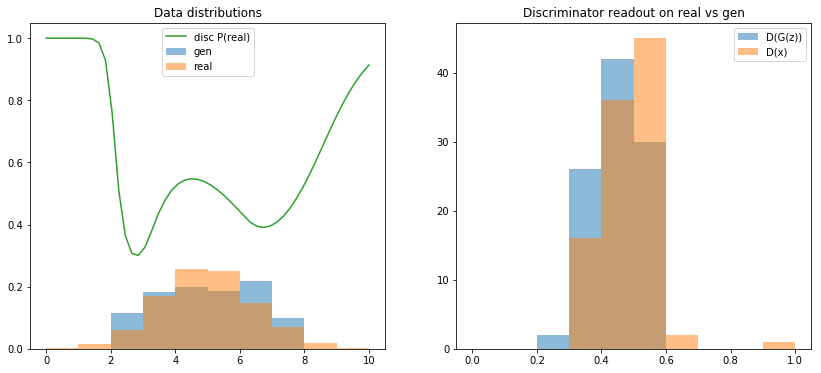

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

for i in range(100000):

    for _ in range(5):
        train_disc(128)
    
    train_gen(128)
    
    if i % 250 == 0:
        clear_output(True)
        plt.figure(figsize=[14, 6])
        plt.subplot(1, 2, 1)
        plt.title("Data distributions")
        plt.hist(gen(sample_noise(1000)).data.numpy()[:, 0], range=[0, 10], alpha=0.5, normed=True, label='gen')
        plt.hist(sample_real_data(1000).data.numpy()[:,0], range=[0, 10], alpha=0.5, normed=True, label='real')
        
        x = np.linspace(0,10, dtype='float32')
        disc_preal = disc(Variable(torch.from_numpy(x[:, None])))
        plt.plot(x, disc_preal.data.numpy(), label='disc P(real)')
        plt.legend()
        

        plt.subplot(1, 2, 2)
        plt.title("Discriminator readout on real vs gen")
        plt.hist(disc(gen(sample_noise(100))).data.numpy(), range=[0, 1], alpha=0.5, label='D(G(z))')
        plt.hist(disc(sample_real_data(100)).data.numpy(),
                 range=[0, 1], alpha=0.5, label='D(x)')
        plt.legend()
        plt.show()

__Что ожидать:__
* __Слева:__ Поначалу два распределения будут выглядеть по-разному, но потом распределение генератора должно совпасть с реальными данными _почти_ везде. Кривая представляет собой решение дискриминатора для всех возможных значений x. Постепенно оно должно приближаться к 0.5 в областях, содержащих много реальных значений.
* __Справа:__ Этот график показывает, как часто дискриминатор назначает определённое значение вероятности истинным и искуственным образцам (они отличаются цветом). Для первых итераций допустимы колебания. После этого, когда генератор достаточно обучится, большая часть значений приблизится к 0.5.
 * Если вместо этого значения сходятся к двум дельта-функциям около 0 (искусственные образцы) и 1 (истинные образцы), то дискриминатор одержал верх над генератором. _Проверьте функцию потерь генератора_. Другим решением является уменьшение скорости обучения дискриминатора. Это также может произойти при замене среднего для батча на сумму или схожую функцию.
 * Если значения сходятся к 0.5 и остаются там на протяжении нескольких итераций, но генератор не научился генерировать правдоподобные образцы, то генератор одержал верх над дискриминатором. _Дополнительно проверьте функцию потерь дискриминатора_.